In [3]:
import pandas as pd
from itertools import combinations
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain

FILTER_RAW_DATASET = False

[Get dataset here](https://nijianmo.github.io/amazon/index.html)

### Filtering

In [4]:
def load_and_filter_raw_dataset(raw_file, filtered_file):
    df = pd.read_json(raw_file, lines=True)
    df = df.loc[df['verified']]
    df.drop(['reviewTime', 'image', 'vote', 'style', 'verified'], inplace=True, axis=1)
    df.to_csv(filtered_file, index=False)
    return df

In [5]:
RAW_DATA_FILE = 'Movies_and_TV_5.json'
FILTERED_DATA_FILE = 'tv.csv'

if FILTER_RAW_DATASET:
    df = load_and_filter_raw_dataset(RAW_DATA_FILE, FILTERED_DATA_FILE)
else:
    df = pd.read_csv(FILTERED_DATA_FILE)

df.head()

,overall,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,5,A2M1CU2IRZG0K9,0005089549,Terri,So sorry I didn't purchase this years ago when...,Amazing!,1352419200
1,5,AFTUJYISOFHY6,0005089549,Melissa D. Abercrombie,Believe me when I tell you that you will recei...,Great Gospel VHS of the Cathedrals!,1325203200
2,5,A3JVF9Y53BEOGC,000503860X,Anthony Thompson,"I have seen X live many times, both in the ear...",A great document of a great band,1114041600
3,5,A12VPEOEZS1KTC,000503860X,JadeRain,"I was so excited for this! Finally, a live co...",YES!! X LIVE!!,1112745600
4,5,ATLZNVLYKP9AZ,000503860X,T. Fisher,X is one of the best punk bands ever. I don't ...,X have still got it,1291334400


### Network

In [6]:
# grouped = df.groupby('asin')['reviewerID'].unique()
# for movie_id, reviewers in grouped.items():
#     if len(set(reviewers)) < 5:
#         print(f"Movie {movie_id} has only {len(set(reviewers))} unique reviewers.")
#         break

In [7]:
def filter_reviews(df, threshold=15):
    prev_shape = (0, 0)
    current_shape = df.shape

    while current_shape != prev_shape:
        prev_shape = current_shape

        review_counts = df.groupby('asin')['reviewerID'].nunique()
        valid_movies = review_counts[review_counts >= threshold].index
        df = df[df['asin'].isin(valid_movies)]

        reviewer_counts = df.groupby('reviewerID')['asin'].nunique()
        valid_reviewers = reviewer_counts[reviewer_counts >= threshold].index
        df = df[df['reviewerID'].isin(valid_reviewers)]

        current_shape = df.shape

    return df

filtered_df = filter_reviews(df)

In [8]:
reviewer_counts = df.groupby('reviewerID')['asin'].nunique()
len(reviewer_counts[reviewer_counts > 500])

4

In [9]:
grouped = filtered_df.groupby('asin')['reviewerID'].unique()

len(grouped)

9412

In [10]:
sum(len(set(reviewers)) < 5 for reviewers in grouped.values)

0

In [11]:
edges = Counter()
for reviewers in tqdm(grouped.values, desc="Movies"):
    for pair in combinations(reviewers, 2):
        edges[pair] += 1

Movies: 100%|██████████| 9412/9412 [00:33<00:00, 278.12it/s] 


In [12]:
edgelist = [(a, b, count) for (a, b), count in edges.items()]
len(edgelist)

30263344

In [13]:
thresholds = [4,5,7,10,15]
for t in thresholds:
    weighted_edges = [(a, b, w) for (a, b, w) in edgelist if w > t]
    print(f"Edges with weight > {t}: {len(weighted_edges)}")

Edges with weight > 4: 470620
Edges with weight > 5: 222151
Edges with weight > 7: 64401
Edges with weight > 10: 15258
Edges with weight > 15: 2498


### Graph

In [14]:
weighted_edges = [(a, b, w) for (a, b, w) in edgelist if w > 5]
len(weighted_edges)

222151

In [15]:
G = nx.Graph()
G.add_weighted_edges_from(weighted_edges)

In [16]:
len(G.nodes()), len(G.edges())

(10663, 218400)

In [17]:
degrees = [d for _, d in G.degree()]

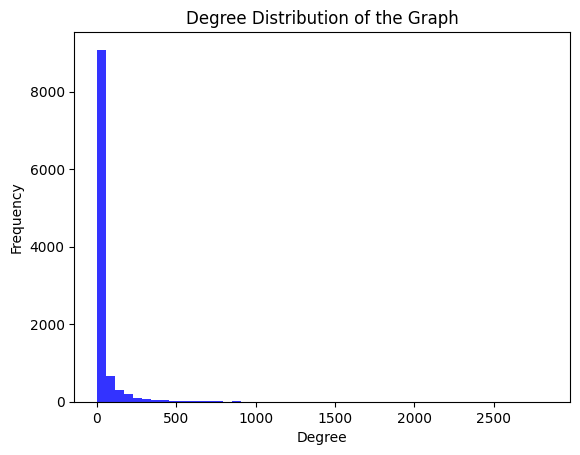

In [18]:
plt.hist(degrees, bins=50, color='blue', alpha=0.8)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of the Graph')
plt.show()

### Community detection

In [19]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

In [ ]:
communities = louvain_partitions(G)
len(communities)